# Install Dependencies

In [140]:
!pip install torch torchvision tqdm torchmetrics torchinfo numpy pandas matplotlib seaborn watermark

# System and Packages

In [141]:
%load_ext watermark
%reload_ext watermark
%watermark -a 'Pushpakant Behera' -m -v -p torch,torchvision,tqdm,torchmetrics,torchinfo,numpy,pandas,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Pushpakant Behera

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.33.0

torch       : 1.11.0
torchvision : 0.12.0
tqdm        : 4.64.0
torchmetrics: 0.11.0
torchinfo   : 1.7.1
numpy       : 1.21.6
pandas      : 1.3.5
matplotlib  : 3.5.3
seaborn     : 0.11.2

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.65+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



# Imports

In [142]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.utils import make_grid

import torchvision
import torchvision.transforms as transforms

import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision,\
                                        MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassConfusionMatrix,\
                                        MulticlassF1Score, MulticlassFBetaScore, MulticlassRecall, MulticlassROC

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

# Configuration

In [143]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 32
BATCH_SIZE = 32
# LEARNING_RATE = 3e-4 # karapathy constant
LEARNING_RATE = 1e-2
SCHEDULER_STEP_SIZE = 16
WEIGHT_DECAY = 1e-6
MOMENTUM = 0.9

CHANNELS = 1
WIDTH = 28
HEIGHT = 28
CLASSES = 10

TRAIN_VALID_RATIO = 0.8

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.cuda.empty_cache()

# Preparing Data

In [144]:
train_transform = transforms.Compose([
  transforms.RandomChoice([transforms.RandomRotation(degrees=20),
                           transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                           transforms.RandomAffine(degrees=0, scale=(0.5, 1.75)),
                           transforms.RandomAffine(degrees=0, shear=(-30, 30, -30, 30)),
                           transforms.GaussianBlur(kernel_size=(3,5), sigma=(0.1, 2)),
                           transforms.TrivialAugmentWide(),
  ], p=[0.5, 0.5, 0.5, 0.3, 0.1, 0.1]),
  transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
  transforms.RandomPerspective(distortion_scale=0.1, p=0.1),
  transforms.ToTensor(),
  transforms.Normalize(0.1307, 0.3081)
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.1307, 0.3081)
])

In [145]:
train_valid_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=train_transform)

train_set_size = int(len(train_valid_dataset) * 0.8)
valid_set_size = len(train_valid_dataset) - train_set_size

train_dataset, valid_dataset = random_split(train_valid_dataset, [train_set_size, valid_set_size])
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=test_transform)

In [146]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# Visualizing Data

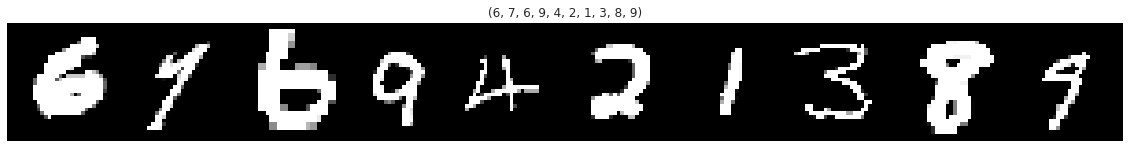

In [147]:
images, labels = zip(*[train_dataset[i] for i in range(10)])

images = torch.stack(images)

fig, ax = plt.subplots(figsize=(20, 10))
grid = make_grid(images, nrow=10, )

plt.title(labels)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

# Model, Loss Function, Optimizer and Scheduler

In [148]:
class MNISTClassifier(nn.Module):
  def __init__(self, channels, classes, dropout_rate):
    super(MNISTClassifier, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(in_features=32 * 7 * 7, out_features=64),
        nn.Dropout(dropout_rate),
        nn.LeakyReLU(0.1),
        nn.Linear(in_features=64, out_features=classes),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    
    # x = torch.flatten(x, start_dim=1)
    x = x.view(x.shape[0], -1) # this is inplace, first parameter is batch size
    
    x = self.classifier(x)
    return x

summary(model=MNISTClassifier(channels=CHANNELS, classes=CLASSES, dropout_rate=0.5), input_size=[BATCH_SIZE, 1, WIDTH, HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
MNISTClassifier                          [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 16, 28, 28]          144
│    └─BatchNorm2d: 2-2                  [32, 16, 28, 28]          32
│    └─ReLU: 2-3                         [32, 16, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 16, 14, 14]          --
├─Sequential: 1-2                        [32, 32, 7, 7]            --
│    └─Conv2d: 2-5                       [32, 32, 14, 14]          4,608
│    └─BatchNorm2d: 2-6                  [32, 32, 14, 14]          64
│    └─LeakyReLU: 2-7                    [32, 32, 14, 14]          --
│    └─MaxPool2d: 2-8                    [32, 32, 7, 7]            --
├─Sequential: 1-3                        [32, 10]                  --
│    └─Linear: 2-9                       [32, 64]                  100,416
│    └

In [149]:
model = MNISTClassifier(channels=CHANNELS, classes=CLASSES, dropout_rate=0.5).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=0.1)

# Metrics Initialization

In [150]:
train_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
]).to(DEVICE)

valid_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
]).to(DEVICE)

test_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
    MulticlassConfusionMatrix(num_classes=CLASSES),
]).to(DEVICE)

train_metrics = []
valid_metrics = []
test_metrics = []

train_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

valid_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

test_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

# Training, Validating and Testing function definition

In [151]:
def train(train_loader, model, criterion, optimizer, train_metrics_coll):
  train_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    model.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, prediction = torch.max(outputs.data, 1)

    batch_metrics = train_metrics_coll.update(outputs, labels)
  
  train_loss /= len(train_loader)
  return train_loss

In [152]:
@torch.inference_mode()
def valid(valid_loader, model, criterion, valid_metrics_coll):
  valid_loss = 0.0
  for i, (images, labels) in enumerate(valid_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)

    valid_loss += loss.item()
    _, prediction = torch.max(outputs.data, 1)

    batch_metrics = valid_metrics_coll.update(outputs, labels)
    
  valid_loss /= len(valid_loader)
  return valid_loss

In [153]:
@torch.inference_mode()
def test(test_loader, model, criterion, test_metrics_coll):
  test_loss = 0.0
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)

    test_loss += loss.item()
    _, prediction = torch.max(outputs.data, 1)

    batch_metrics = test_metrics_coll.update(outputs, labels)
    
  test_loss /= len(test_loader)
  return test_loss

# Training and Validation

In [154]:
for epoch in tqdm(range(1, EPOCHS + 1)):
  train_metrics_coll.reset(), valid_metrics_coll.reset()

  model.train()
  train_loss = train(train_loader, model, criterion, optimizer, train_metrics_coll)
  
  scheduler.step()
    
  model.eval()
  valid_loss = valid(valid_loader, model, criterion, valid_metrics_coll)

  tr_met = train_metrics_coll.compute()
  vl_met = valid_metrics_coll.compute()

  train_metrics.append(tr_met)
  valid_metrics.append(vl_met)

  train_metrics_vals['loss'].append(train_loss)
  valid_metrics_vals['loss'].append(valid_loss)

  if not epoch % 10 or epoch == EPOCHS:
    print(f'Epoch: {epoch}')
    print(f'Train Loss: {train_loss}, Train Accuracy: {tr_met["MulticlassAccuracy"]}')
    print(f'Valid Loss: {valid_loss}, Valid Accuracy: {vl_met["MulticlassAccuracy"]}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10
Train Loss: 0.19042614615770678, Train Accuracy: 0.945270836353302
Valid Loss: 0.11514689042170842, Valid Accuracy: 0.9669166803359985
Epoch: 20
Train Loss: 0.1335711843871201, Train Accuracy: 0.9603750109672546
Valid Loss: 0.09121614052417377, Valid Accuracy: 0.9742500185966492
Epoch: 30
Train Loss: 0.12965211210850006, Train Accuracy: 0.9627708196640015
Valid Loss: 0.0979211838496849, Valid Accuracy: 0.9702500104904175
Epoch: 32
Train Loss: 0.1272558457159903, Train Accuracy: 0.9636458158493042
Valid Loss: 0.08766979667544365, Valid Accuracy: 0.9740833044052124


# Training and Validation Metrics

In [155]:
print(f"Validation Accuracy: {valid_metrics[len(valid_metrics) - 1]['MulticlassAccuracy'].item()}")

Validation Accuracy: 0.9740833044052124


In [156]:
for key, _ in train_metrics_coll.items():
    print(f'{key}: {train_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.9636458158493042
MulticlassPrecision: 0.9633961915969849
MulticlassRecall: 0.9634767770767212
MulticlassFBetaScore: 0.9634469747543335


In [157]:
for key, _ in valid_metrics_coll.items():
    print(f'{key}: {valid_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.9740833044052124
MulticlassPrecision: 0.9740089178085327
MulticlassRecall: 0.9740674495697021
MulticlassFBetaScore: 0.9740366339683533


In [210]:
for metric in train_metrics:
    train_metrics_vals['accuracy'].append(metric['MulticlassAccuracy'].cpu())
    train_metrics_vals['precision'].append(metric['MulticlassPrecision'].cpu())
    train_metrics_vals['recall'].append(metric['MulticlassRecall'].cpu())
    train_metrics_vals['fBetaScore'].append(metric['MulticlassFBetaScore'].cpu())
    
for metric in valid_metrics:
    valid_metrics_vals['accuracy'].append(metric['MulticlassAccuracy'].cpu())
    valid_metrics_vals['precision'].append(metric['MulticlassPrecision'].cpu())
    valid_metrics_vals['recall'].append(metric['MulticlassRecall'].cpu())
    valid_metrics_vals['fBetaScore'].append(metric['MulticlassFBetaScore'].cpu())

# Training and Validation Plots

In [211]:
plt.rcParams["figure.figsize"] = (10, 5)

## Loss

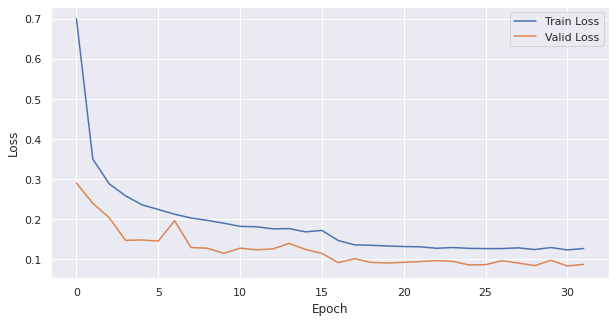

In [212]:
plt.plot(train_metrics_vals['loss'], label="Train Loss")
plt.plot(valid_metrics_vals['loss'], label="Valid Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Accuracy

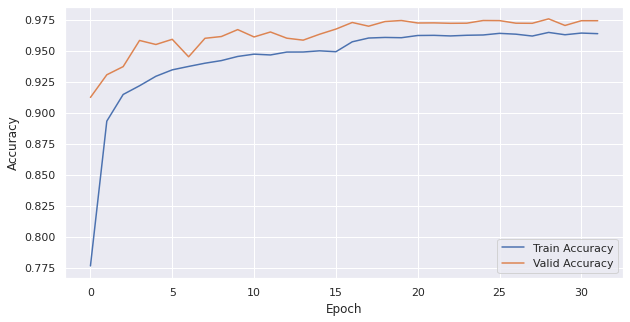

In [213]:
plt.plot(train_metrics_vals['accuracy'], label="Train Accuracy")
plt.plot(valid_metrics_vals['accuracy'], label="Valid Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Precision

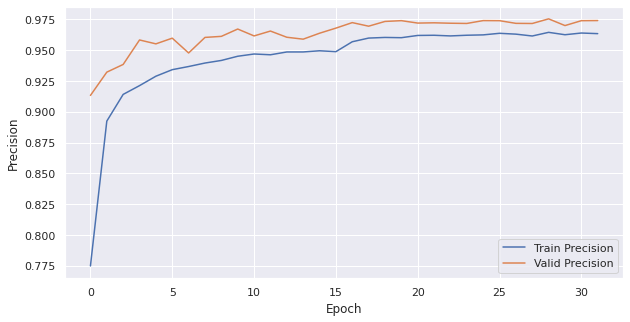

In [214]:
plt.plot(train_metrics_vals['precision'], label="Train Precision")
plt.plot(valid_metrics_vals['precision'], label="Valid Precision")

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Recall

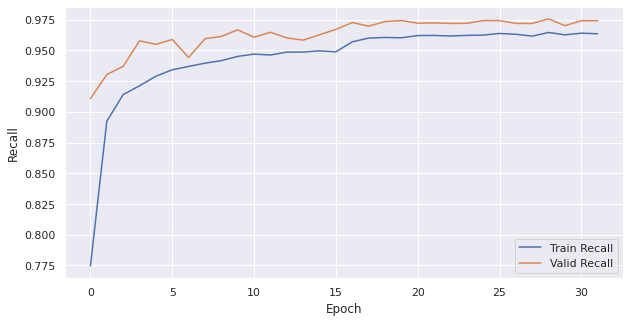

In [215]:
plt.plot(train_metrics_vals['recall'], label="Train Recall")
plt.plot(valid_metrics_vals['recall'], label="Valid Recall")

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

## F-Beta Score

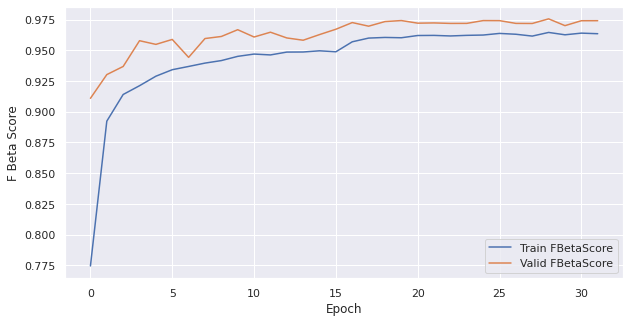

In [216]:
plt.plot(train_metrics_vals['fBetaScore'], label="Train FBetaScore")
plt.plot(valid_metrics_vals['fBetaScore'], label="Valid FBetaScore")

plt.xlabel("Epoch")
plt.ylabel("F Beta Score")
plt.legend()
plt.show()

# Testing

In [217]:
model.eval()
test_loss = test(test_loader, model, criterion, test_metrics_coll)
te_met = test_metrics_coll.compute()
test_metrics.append(te_met)
print(f'Test Loss: {test_loss}')

Test Loss: 0.01565309487406526


# Test Metrics

In [218]:
for key, _ in test_metrics_coll.items():
    print(f'{key}: {test_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.9950000047683716
MulticlassPrecision: 0.9950143098831177
MulticlassRecall: 0.994965672492981
MulticlassFBetaScore: 0.9949741959571838
MulticlassConfusionMatrix: tensor([[5862,    0,   12,    0,    0,    0,    0,    6,    0,    0],
        [   0, 6780,    6,    6,    0,    0,    6,   12,    0,    0],
        [  12,    0, 6174,    0,    0,    0,    0,    6,    0,    0],
        [   0,    0,    0, 6042,    0,   12,    0,    6,    0,    0],
        [   0,    0,    0,    0, 5850,    0,    0,    0,   12,   30],
        [   6,    0,    0,   18,    0, 5316,    6,    6,    0,    0],
        [  12,   12,    0,    0,    6,    0, 5712,    0,    6,    0],
        [   0,   12,    6,    0,    6,    0,    0, 6144,    0,    0],
        [   0,    0,    6,    0,    6,    0,    0,    0, 5826,    6],
        [   6,    0,    0,    0,   30,    6,    0,   12,    6, 5994]],
       device='cuda:0')


# Confusion Matrix

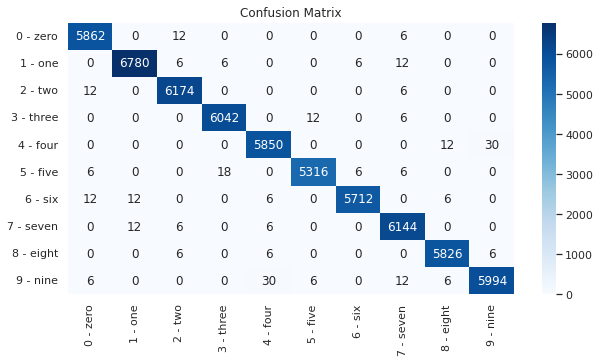

In [219]:
df_cm = pd.DataFrame(test_metrics[len(test_metrics) - 1]['MulticlassConfusionMatrix'].cpu().numpy(), index = train_valid_dataset.classes, columns = train_valid_dataset.classes)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d').set_title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()

# Export Model

In [169]:
model.eval()
dummy_input = torch.randn(1, 1, 28, 28, requires_grad=False).to(DEVICE)

torch.onnx.export(model, dummy_input, "model.onnx", export_params=True)